# Użycie narzędzi scikit-learn do wizualizacji małych zbiorów danych - MDS, LLE i Isomap

In [1]:
#Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import MDS, LocallyLinearEmbedding, Isomap
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from random import randint
from mpl_toolkits import mplot3d
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import cdist


In [5]:
#utils

def draw(title, final_df, targets, colors):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1)
    ax.set_xlabel('Component 1', fontsize = 15)
    ax.set_ylabel('Component 2', fontsize = 15)
    ax.set_title(title, fontsize = 20)

    for target, color in zip(targets, colors):
        indicesToKeep = final_df['target'] == target
        ax.scatter(final_df.loc[indicesToKeep, 'component 1']
                   , final_df.loc[indicesToKeep, 'component 2']
                   , c = color
                   , s = 100)
    ax.legend(targets)
    ax.grid()
    plt.show()
    
    
def generate_points_on_sphere(r):
    beta = np.random.rand(100) * 2 * np.math.pi
    alpha = np.random.rand(100) * np.math.pi - np.math.pi / 2
    x = (r * np.cos(alpha) * np.cos(beta))
    y = (r * np.cos(alpha) * np.sin(beta))
    z = (r * np.sin(alpha))
    return x, y, z


def draw_3D(xs, ys, zs, xs2, ys2, zs2):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xs, ys, zs, zdir='z', s=100, c='red', depthshade=True)
    ax.scatter(xs2, ys2, zs2, zdir='z', s=100, c='blue', depthshade=True)
    plt.show()
    
    
def draw_shepard(d1,d2):
    in_distance = cdist(d1, d1, 'euclidean').flatten()
    out_distance = cdist(d2, d2, 'euclidean').flatten()
    plt.scatter(in_distance, out_distance, c='blue')
    plt.show()

    
def nearest_neighbors(k, original_data, transformed_data):
    neig = NearestNeighbors(n_neighbors=k, algorithm='kd_tree')
    neig.fit(original_data)
    in_d = np.array([])
    out_d = np.array([])
    for i in range(original_data.shape[0]):
        in_d = np.append(in_d, neig.kneighbors([original_data[i]], return_distance=False))

    neig.fit(transformed_data)
    for i in range(transformed_data.shape[0]):
        out_d = np.append(out_d, neig.kneighbors([transformed_data[i]], return_distance=False))
    # bierzemy ilość pokrywających się odejmujemy to że się same ze sobą pokrywają i dzielimy przez rozmiar wszystkich
    print((len(np.extract(in_d == out_d, out_d)) - 200) / (len(out_d) - 200))

## Dlaczego nie można używać PCA do każdego przypadku?

Mamy do zwizualizowania sferę w sferze:

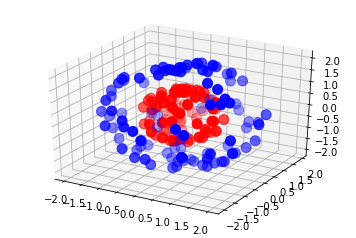

In [4]:
# Wygeneruj losowe punkty na dwóch sferach jedna w drugiej
xs, ys, zs = generate_points_on_sphere(1)
xs2, ys2, zs2 = generate_points_on_sphere(2)

draw_3D(xs, ys, zs, xs2, ys2, zs2)

### Obliczanie oraz wizualizacja przy użyciu PCA:

In [5]:
# Zrób frame'a
datax = np.append(xs,xs2)
datay = np.append(ys,ys2)
dataz = np.append(zs,zs2)
target = np.append(np.array(['sphere1' for x in range(0, 100)]), np.array(['sphere2' for x in range(0, 100)]))
dataset = pd.DataFrame({'x': datax, 'y':datay, 'z':dataz, 'target': target})

features = ['x', 'y', 'z']
x = dataset.loc[:, features].values
x = StandardScaler().fit_transform(x)

# Policz PCA
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x)
df_pca = pd.DataFrame(data = x_pca, columns = ['component 1', 'component 2'])
finalDf = pd.concat([df_pca, dataset[['target']]], axis = 1)

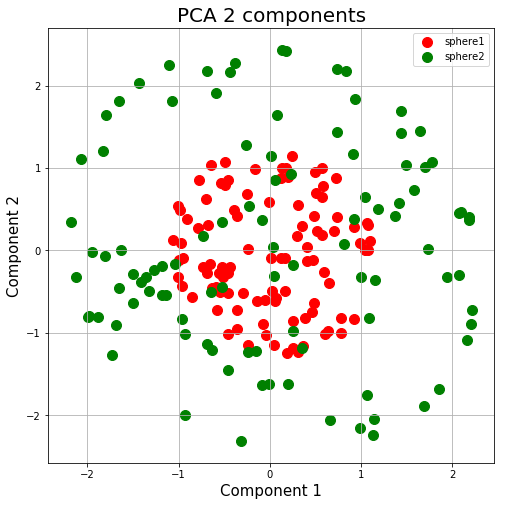

In [6]:
draw("PCA 2 components", finalDf)

## Nic nie wyszło...

![image.png](http://www.quickmeme.com/img/57/57a6300833a6fba4f79200ae99a57c3087e7efce292a105c6c47dd74e2ed9a9c.jpg)

![image.png](https://media.tenor.com/images/0d39f1116e04f6463d67293e3e9e8f98/tenor.png)

## Ponieważ wartości własne są takie same:

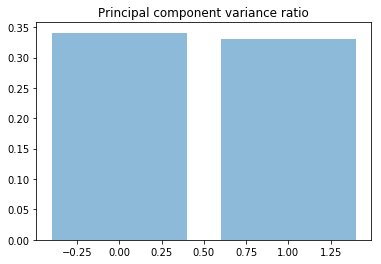

In [7]:
#wartości własne PCA
plt.bar(range(pca.explained_variance_ratio_.shape[0]), pca.explained_variance_ratio_, align='center', alpha=0.5)
plt.title('Principal component variance ratio')
plt.show()

![image.png](https://memegenerator.net/img/instances/65225807/well-what-do-we-do-now.jpg)

# Metody z modułu Mainfold:

Manifold learning is an approach to non-linear dimensionality reduction. Algorithms for this task are based on the idea that the dimensionality of many data sets is only artificially high.

[Manual](https://scikit-learn.org/stable/modules/manifold.html)

### Jakie podejścia są dostępne w module?
- MDS (Multi-dimensional Scaling)
- Isomap (Isometric Mapping), de facto rozszerzenie MDS lub Kernel PCA
- Locally Linear Embedding (w skrócie jest to seria PCA które są potem globalnie porównywane)

### MDS
- Wiemy czyms jest PCA (albo zakładamy że mamy jakieś pojęcie)
- (W szczególnym, przykładowym przypadku) PCA przekłada korelacje na graf 2D
- W MDS jest podobnie ale zamiast korelacji przekłada dystans między punktami na graf 2D (pair-wise distance)

Super, ale jak wyznaczyć dystans?
- Eukidesowy
- Geodezyjny
- i wiele, wiele innych

### Dygresja:
Jak działa dystans geodezyjny?

![image.png](https://i.stack.imgur.com/03uG3.png)

Jak się taki dystans liczy?
- Najczęściej jako suma odległości eukidesowej między punktami znajdującymi się na najkrótszej ścieżce z A do B

Fun fact: Co by się stało jakbyśmy użyli w PCA dystansu eukidesowego?

### Koniec dygresji

W takim razie sam algorytm musi być bardzo podobny?

>Classic Torgerson's metric MDS is actually done by transforming distances into similarities and performing PCA (eigen-decomposition or singular-value-decomposition) on those.

Jeśli masz wolne 8 minut i chcesz trochę innego wytłumaczenia MDS: [MDS w 8 min](https://www.youtube.com/watch?v=GEn-_dAyYME)

Krótko o PCA vs MDS: [stack](https://stats.stackexchange.com/questions/14002/whats-the-difference-between-principal-component-analysis-and-multidimensional)

### Co zrobić z takim czymś?
![image.png](https://www.researchgate.net/profile/Xing_Li7/publication/238702963/figure/fig2/AS:298718092906506@1448231351602/An-Example-of-Data-Manifold-the-Swiss-roll-Dots-represent-the-data_W640.jpg)

Po pierwsze co to jest?
- Manifold? Ale tak formalnie?

>In mathematics, a manifold is a topological space that locally resembles Euclidean space near each point 
[source](https://en.wikipedia.org/wiki/Manifold)

Co jest naszym zadaniem w takiej sytuacji? Jak chcielibyśmy takie coś zwizuwalizować w 2D?

### Isomap
- Pierwsze podejście nieliniowe
- W dużym uproszczeniu MDS z dystansem eukidesowym.

Kroki:
- Zbuduj graf k-najbliższych sąsiadków, gdzie k jest parametrem wejściowym
- Wylicz wszystkie najkrótsze ścieżki dla par punktów
- Uzyj MDS

[source](https://slideplayer.com/slide/8699258/)

Co będzie lepsze i dlaczego?
- PCA i odległość eukidesowa
- Isomap z odległością geodezyjna

![image.png](http://benalexkeen.com/wp-content/uploads/2017/05/isomap.png)

A -> zwykły dystans eukidesowy
B -> graf k-najbliższych sąsiadów i dalej najkrótsze ścieżki zgodnie z Dijkstrą. W tym przypadku K=7
C -> Wykonanie klasycznego MDS na danych

Oczywiście algorytm Dijkstry nie jest jedynym. Nie jest też nawet zawsze poprawnym. Możemy też użyć Floyd–Warshall-a.

[Prosty przykład](http://benalexkeen.com/isomap-for-dimensionality-reduction-in-python/)

### LLE (Locally Linear Embedding)
- Podejście również nieliniowe

Algorytm:

![image.gif](https://cs.nyu.edu/~roweis/lle/images/llef2med.gif)
[source](https://cs.nyu.edu/~roweis/lle/algorithm.html)

>Input X: D by N matrix consisting of N data items in D dimensions.
Output Y: d by N matrix consisting of d < D dimensional embedding coordinates for the input points.


>Find neighbours in X space [b,c].
for i=1:N
  compute the distance from Xi to every other point Xj
  find the K smallest distances 
  assign the corresponding points to be neighbours of Xi
end

>Solve for reconstruction weights W.
for i=1:N
  create matrix Z consisting of all neighbours of Xi [d]
  subtract Xi from every column of Z
  compute the local covariance C=Z'*Z [e]
  solve linear system C*w = 1 for w [f]
  set Wij=0 if j is not a neighbor of i
  set the remaining elements in the ith row of W equal to w/sum(w);
end

>Compute embedding coordinates Y using weights W.
create sparse matrix M = (I-W)'*(I-W)
find bottom d+1 eigenvectors of M
  (corresponding to the d+1 smallest eigenvalues) 
set the qth ROW of Y to be the q+1 smallest eigenvector
  (discard the bottom eigenvector [1,1,1,1...] with eigenvalue zero)

Co w tym jest naprawdę ważne?
- możemy rekonstruować punkty na podstawie wag ich sąsiadów. Dlatego też jeśli coś nie jest w k-nearest to ma wagę 0, nie dodaje się to do naszego procesu odtwarzania.

### LLE vs Isomap
- Isomap jest podejściem globalnym a LLE lokalnym
- Isomap wymaga podejścia dynamicznego do implementacji a LLE już nie, dzięki czemu zwykle jest bardziej efektywne obliczeniowo.

Krótka prezentacja na ten temat: [source](http://people.cs.pitt.edu/~milos/courses/cs3750-Fall2011/lectures/class16.pdf)

### Dlaczego?
- PCA jest zaliczane do metod liniowych, ale skupia sie na projekcji liniowej pasywnie ignorując resztę danych
- Mainfold Learning stara się uczyć się bezpośrednio z danych, dzięki czemu nie używa z góry określonych klasyfikatorów

## Uff przeszliśmy przez teorie
![image.jpg](http://i.imgur.com/SFd2QFq.jpg)

## MDS

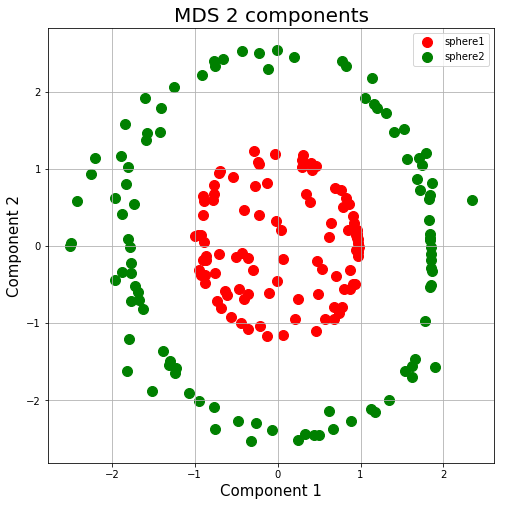

In [8]:
#MDS defaultowe
mds = MDS(n_components=2)
x_mds = mds.fit_transform(x)
df_mds = pd.DataFrame(data = x_mds, columns = ['component 1', 'component 2'])
finalDf = pd.concat([df_mds, dataset[['target']]], axis = 1)

#Draw MDS
draw("MDS 2 components", finalDf)

![image.png](https://sayingimages.com/wp-content/uploads/the-annoyed-man-not-bad-meme.jpg)

## LLE (Locally Linear Embedding)

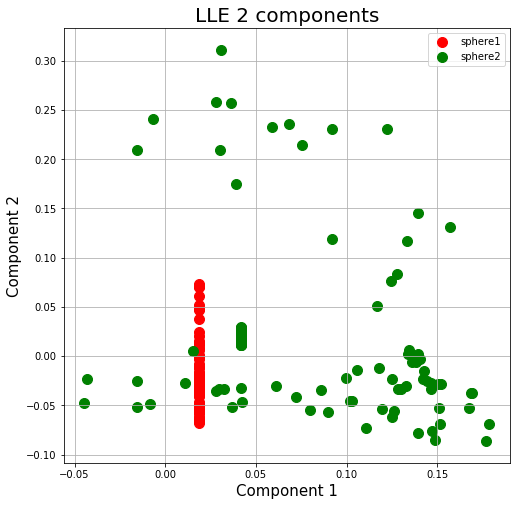

In [9]:
# LLE defaultowe
lle = LocallyLinearEmbedding(n_components=2)
x_lle = lle.fit_transform(x)
df_lle = pd.DataFrame(data = x_lle, columns = ['component 1', 'component 2'])
finalDf = pd.concat([df_lle, dataset[['target']]], axis = 1)

# draw LLE
draw("LLE 2 components", finalDf)

## A co z Isomap?

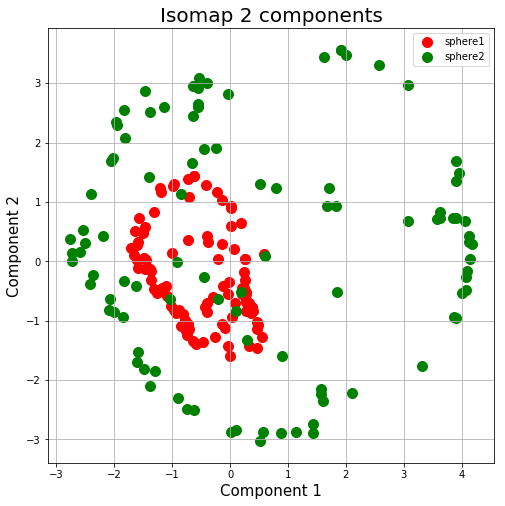

In [10]:
iso = Isomap(n_components=2)
x_iso = iso.fit_transform(x)
df_iso = pd.DataFrame(data = x_iso, columns = ['component 1', 'component 2'])
finalDf = pd.concat([df_iso, dataset[['target']]], axis = 1)

# draw Isomap
draw("Isomap 2 components", finalDf)

## Shepard diagram

Diagram sheparda przedstawia na wykresie zleżność odległości rzeczywistej punktów i ich odległości po przekształceniu.

Ponieważ bierze on pod uwagę dystanse między każdą parą punktów ilośc powstałych punktów na wykresie dla N początkowych wynosi N^2. Dlatego najpiew potrzebujemy zminiejszyć ilość danych.

In [11]:
#za dużo danych bierzemy tylko 15pkt.
def cutData(datax, datay, dataz, outx, outy):
        is1x = datax[:15]
        is1y = datay[:15]
        is1z = dataz[:15]
        is2x = datax[100:115]
        is2y = datay[100:115]
        is2z = dataz[100:115]

        os1x = outx[:15]
        os1y = outy[:15]
        os2x = outx[100:115]
        os2y = outy[100:115]
        d = np.column_stack((np.append(is1x, is2x), np.append(is1y, is2y), np.append(is1z, is2z)))
        d2 = np.column_stack((np.append(os1x, os2x), np.append(os1y, os2y)))
        return d, d2

Diagram sheparda dla niezmienionych danych powinien być linią prostą ponieważ punkty przed i po przekształceniu mają tą samą odległosć.

No transformation


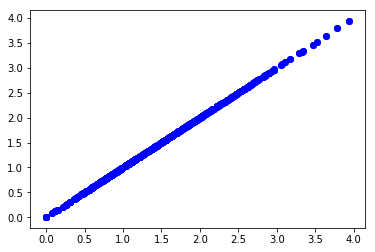

In [12]:
print("No transformation")
#shepard diagram for no transformation
d, dd = cutData(datax, datay, dataz, datax, datay)
draw_shepard(d[:,:2], dd)

ISO


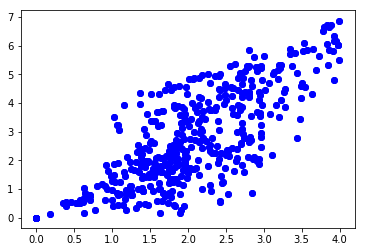

In [13]:
print("ISO")
#sheprad diagram for ISO
d, x_iso_d = cutData(datax, datay, dataz,x_iso[:,0], x_iso[:,1])
draw_shepard(d, x_iso_d)

MDS


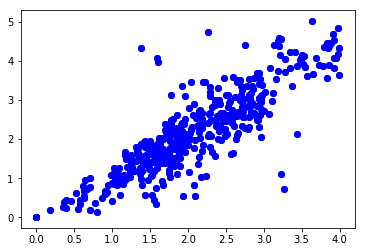

In [14]:
print("MDS")
#sheprad diagram for MDS
d, x_mds_d = cutData(datax, datay, dataz,x_mds[:,0], x_mds[:,1])
draw_shepard(d, x_mds_d)

LLE


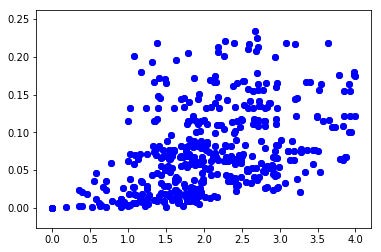

In [15]:
print("LLE")
#sheprad diagram for LLE
d, x_lle_d = cutData(datax, datay, dataz,x_lle[:,0], x_lle[:,1])
draw_shepard(d, x_lle_d)

## Zachowanie najbliższych sąsiadów przez przekształcenie

Sprawdzamy w jakim stopniu punkty po przekształceniu zachowują najbliższych sąsiadów. 
Do znalezienia najbliższych sąsiadów używamy algorytmu kd drzew.

In [16]:
#dla niezmienionych danych powinno być 1.0
data = np.column_stack((datax, datay, dataz))
nearest_neighbors(3, data, data)

1.0


In [17]:
#MDS
nearest_neighbors(3, data, x_mds)

0.2875


In [18]:
#ISO
nearest_neighbors(3, data, x_iso)

0.26


In [19]:
#LLE
nearest_neighbors(3, data, x_lle)

0.2


## Zadanie
+ Metody MDS, LLE oraz Isomap przyjmują różne parametry. Dotychczas zaprezentowano ich wersje domyślne. W ramach zadania należy zbadać wyniki MDS, LLE oraz Isomap dla zmienionych parametrów.

In [11]:
def generate_point(rmax, shift, label):
    beta = np.random.rand() * 2 * np.math.pi
    alpha = np.random.rand() * np.math.pi - np.math.pi / 2
    x = (rmax * np.cos(alpha) * np.cos(beta)) + shift
    y = (rmax * np.cos(alpha) * np.sin(beta)) + shift
    z = (rmax * np.sin(alpha)) + shift
    rest = []
    for i in range(0, 100):
        r = np.random.rand() * rmax * 1.1
        f = (r * np.cos(alpha) * np.cos(beta)) + shift
        rest.append(f)
    features = [x, y, z, label]
    features.extend(rest)
    return features

set1 = []
set2 = []
featuresNames = ['x', 'y', 'z', 'target']
randomFeaturesNames = []

for i in range(1,101):
    randomFeaturesNames.append("feature" + str(i))

featuresNames.extend(randomFeaturesNames)

for i in range(0,100):
    set1.append(generate_point(3.5, 0, 'sphere1'))
    set2.append(generate_point(3.5, 3, 'sphere2'))
    
features = ['x', 'y', 'z']
features.extend(randomFeaturesNames)
data = set1 + set2
dataset = pd.DataFrame(data, columns = featuresNames)
x = dataset.loc[:, features].values
x = StandardScaler().fit_transform(x)
dataset.head

<bound method NDFrame.head of             x         y         z   target  feature1  feature2  feature3  \
0    1.180791  2.652817  1.954046  sphere1  1.235225  0.843873  1.232165   
1   -1.363026  3.200449  0.386375  sphere1 -1.216273 -0.530656 -1.097655   
2   -3.186812 -1.418296 -0.287517  sphere1 -1.891719 -3.122622 -1.721136   
3   -0.974349  2.458180 -2.293032  sphere1 -0.675129 -0.823181 -1.071709   
4    2.778778 -0.484510  2.072111  sphere1  1.639888  0.676120  0.498109   
5   -0.274204  0.479027 -3.456204  sphere1 -0.102396 -0.188507 -0.291792   
6    3.350277 -0.060359  1.010941  sphere1  1.948192  2.863121  1.893538   
7   -0.227460 -0.089494  3.491454  sphere1 -0.005284 -0.114489 -0.217768   
8   -1.278338 -1.196235 -3.030656  sphere1 -0.567966 -0.406279 -0.237757   
9   -1.520723 -2.485539  1.938942  sphere1 -0.254157 -0.997400 -0.006405   
10   0.147758 -0.062481 -3.496321  sphere1  0.081436  0.130546  0.041235   
11   0.723967  0.261957 -3.414272  sphere1  0.030270  0.06

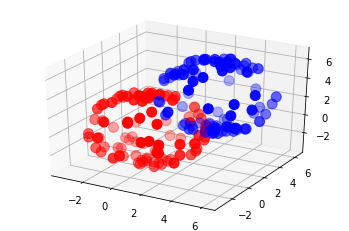

In [4]:
# narysuj w 3D
s1 = dataset[dataset['target'] == 'sphere1']
s2 = dataset[dataset['target'] == 'sphere2']
xs = s1.loc[:, 'x'].values
ys = s1.loc[:, 'y'].values
zs = s1.loc[:, 'z'].values
xs2 = s2.loc[:, 'x'].values
ys2 = s2.loc[:, 'y'].values
zs2 = s2.loc[:, 'z'].values
draw_3D(xs, ys, zs, xs2, ys2, zs2)

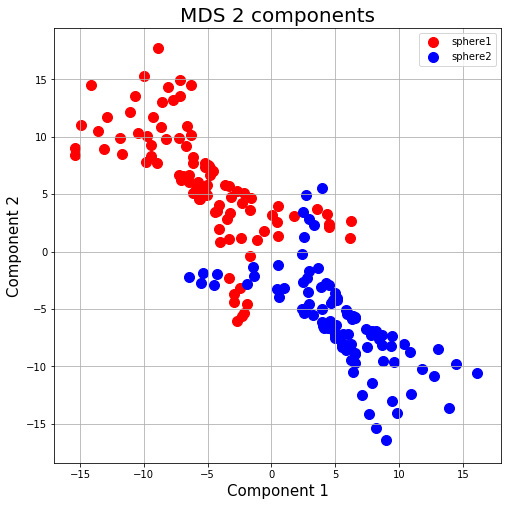

In [8]:
mds = MDS(n_components=2)
x_mds = mds.fit_transform(x)
df_mds = pd.DataFrame(data = x_mds, columns = ['component 1', 'component 2'])
finalDf = pd.concat([df_mds, dataset[['target']]], axis = 1)
draw("MDS 2 components", finalDf, ['sphere1', 'sphere2'], ['r', 'b'])

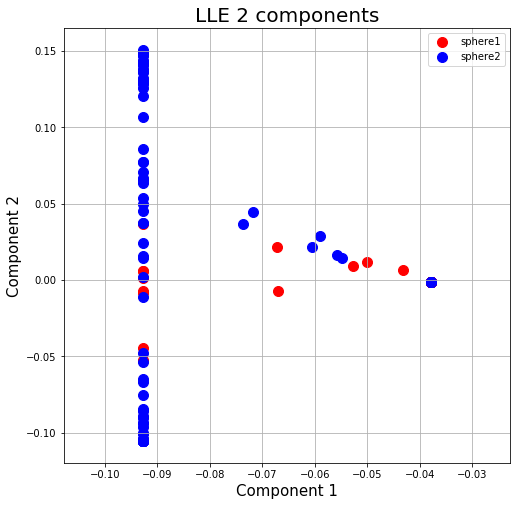

In [9]:
lle = LocallyLinearEmbedding(n_components=2)
x_lle = lle.fit_transform(x)
df_lle = pd.DataFrame(data = x_lle, columns = ['component 1', 'component 2'])
finalDf = pd.concat([df_lle, dataset[['target']]], axis = 1)

# draw LLE
draw("LLE 2 components", finalDf, ['sphere1', 'sphere2'], ['r', 'b'])

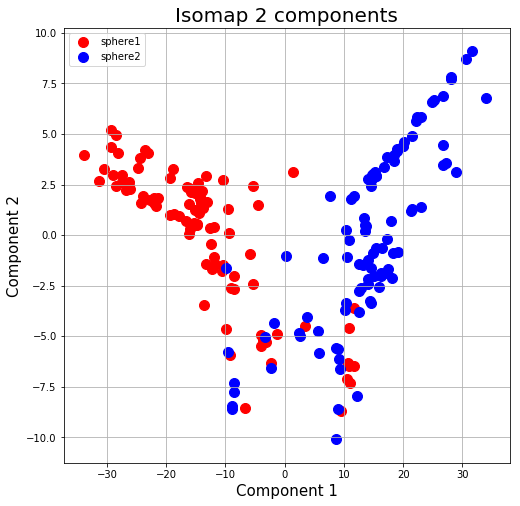

In [10]:
iso = Isomap(n_components=2)
x_iso = iso.fit_transform(x)
df_iso = pd.DataFrame(data = x_iso, columns = ['component 1', 'component 2'])
finalDf = pd.concat([df_iso, dataset[['target']]], axis = 1)

# draw Isomap
draw("Isomap 2 components", finalDf, ['sphere1', 'sphere2'], ['r', 'b'])

+ Porównanie wartości metryk nearest neighbours (NN) oraz k-nearest neighbours (kNN) dla różnych metod na zbiorze smallNORB. Dla metod PCA, MDS, LLE, ISOMAP
+ to do zadania 2???
+ 4 metody pca, lls....
+ diagramy sheparda
+ metryki nn1 nn10 kn3 kn10 i to dla zbioru 2d i oryginalnego(tylko nn)

In [3]:
# przygotowanie danych
smallnorb_path = './smallnorb.csv'
dataset = pd.read_csv(smallnorb_path, sep=',', nrows=1000, header=None)
x = StandardScaler().fit_transform(dataset)
dataset.rename(columns={30: "target"}, inplace=True)

D:\Users\milek\Anaconda3\envs\PCA\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Users\milek\Anaconda3\envs\PCA\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


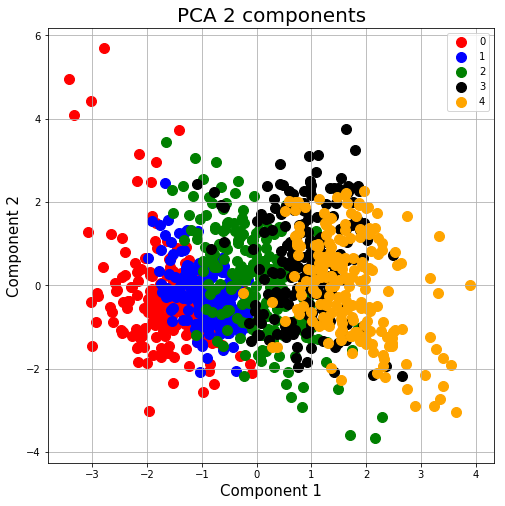

In [21]:
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x)
df_pca = pd.DataFrame(data = x_pca, columns = ['component 1', 'component 2'])
finalDf = pd.concat([df_pca, dataset[['target']]], axis = 1)
targets = [0, 1, 2, 3, 4]
colors = ['r', 'b', 'g', 'black', 'orange']
pointsTarget = dataset[['target']]
draw("PCA 2 components", finalDf, targets, colors)

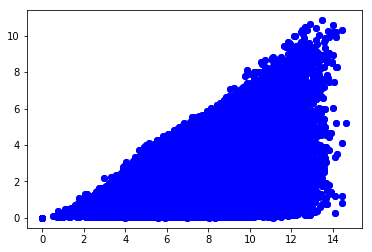

In [23]:
draw_shepard(x, x_pca)

In [35]:
print(knn(3, x, x_pca))
print(knn(10, x, x_pca))
print(nn(x, pointsTarget.values, 1))
print(nn(x, pointsTarget.values, 10))
print(nn(x_pca, pointsTarget.values, 1))
print(nn(x_pca, pointsTarget.values, 10))

0.027
0.013333333333333334
0.915
0.716399999999999
0.586
0.589699999999999


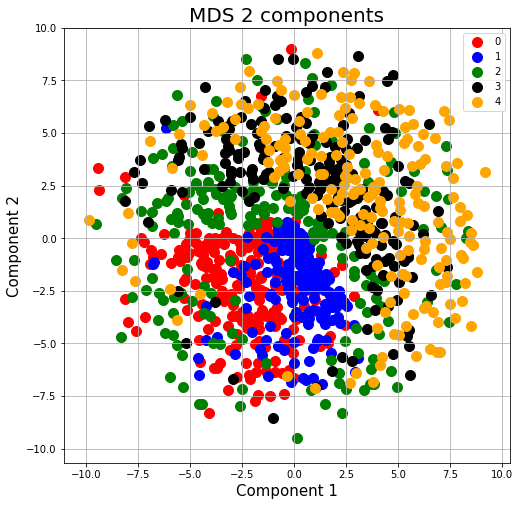

In [8]:
mds = MDS(n_components=2)
x_mds = mds.fit_transform(x)
df_mds = pd.DataFrame(data = x_mds, columns = ['component 1', 'component 2'])
finalDf = pd.concat([df_mds, dataset[['target']]], axis = 1)

#Draw MDS
draw("MDS 2 components", finalDf, targets, colors)

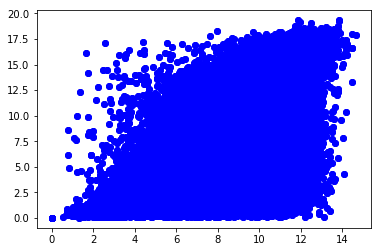

In [107]:
draw_shepard(x, x_mds)

In [36]:
print(knn(3, x, x_mds))
print(knn(10, x, x_mds))
print(nn(x_mds, pointsTarget.values, 1))
print(nn(x_mds, pointsTarget.values, 10))

0.0395
0.016777777777777777
0.53
0.524499999999999


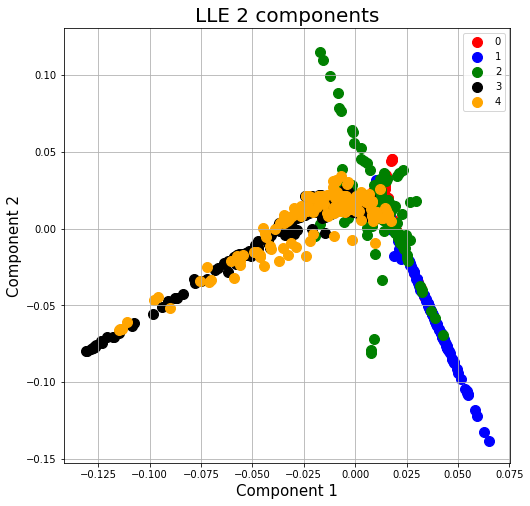

In [9]:
lle = LocallyLinearEmbedding(n_components=2)
x_lle = lle.fit_transform(x)
df_lle = pd.DataFrame(data = x_lle, columns = ['component 1', 'component 2'])
finalDf = pd.concat([df_lle, dataset[['target']]], axis = 1)

draw("LLE 2 components", finalDf, targets, colors)

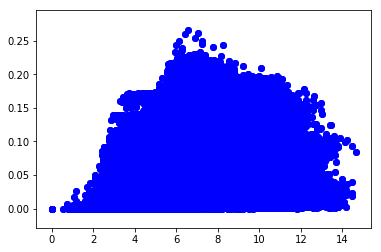

In [108]:
draw_shepard(x, x_lle)

In [37]:
print(knn(3, x, x_lle))
print(knn(10, x, x_lle))
print(nn(x_lle, pointsTarget.values, 1))
print(nn(x_lle, pointsTarget.values, 10))

0.0895
0.03122222222222222
0.613
0.5422


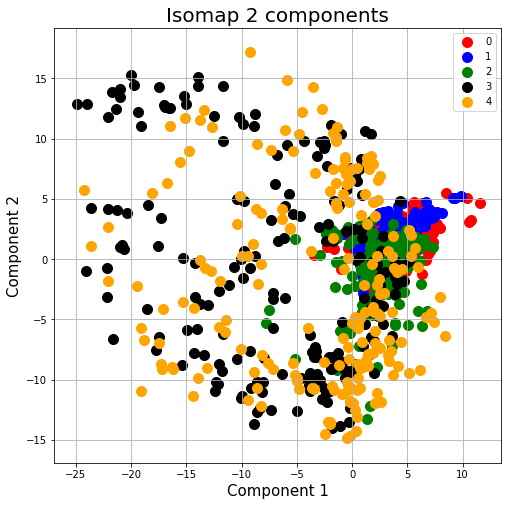

In [10]:
iso = Isomap(n_components=2)
x_iso = iso.fit_transform(x)
df_iso = pd.DataFrame(data = x_iso, columns = ['component 1', 'component 2'])
finalDf = pd.concat([df_iso, dataset[['target']]], axis = 1)

# draw Isomap
draw("Isomap 2 components", finalDf, targets, colors)

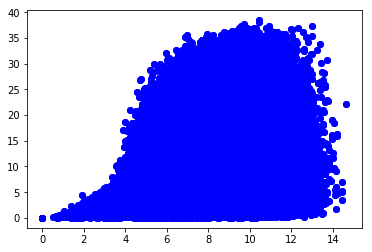

In [109]:
draw_shepard(x, x_iso)

In [38]:
print(knn(3, x, x_iso))
print(knn(10, x, x_iso))
print(nn(x_iso, pointsTarget.values, 1))
print(nn(x_iso, pointsTarget.values, 10))

0.068
0.026555555555555554
0.463
0.43339999999999973


In [11]:
def knn(k: int, original_data: np.ndarray, transformed_data: np.ndarray) -> float:
    neig = NearestNeighbors(n_neighbors=k, algorithm='kd_tree')
    neig.fit(original_data)
    in_d = np.array([])
    out_d = np.array([])
    for i in range(original_data.shape[0]):
        in_d = np.append(in_d, neig.kneighbors([original_data[i]], return_distance=False))

    neig.fit(transformed_data)
    for i in range(transformed_data.shape[0]):
        out_d = np.append(out_d, neig.kneighbors([transformed_data[i]], return_distance=False))
    # bierzemy ilość pokrywających się odejmujemy to że się same ze sobą pokrywają i dzielimy przez rozmiar wszystkich
    return ((len(np.extract(in_d == out_d, out_d)) - original_data.shape[0]) / (len(out_d) - original_data.shape[0]))

def nn(data: np.ndarray, labels: np.ndarray, k: int = 10) -> float:
    neighbours = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree').fit(data)
    _, indices = neighbours.kneighbors(data) # indices[v] zawiera listę jego k+1 najbliższych sąsiadów, wśród nich jest również v
    acc = 0
    for index in range(data.shape[0]):
        same_class = 0
        for n in indices[index][1:]:
            if labels[index] == labels[n]:
                same_class += 1
        acc += same_class / k
    return acc / data.shape[0]

0.068